# Model training and prediction - `s30d`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
os.getcwd()

'/Users/ludvigwarnberggerdin/projects/ttris/pemett'

In [4]:
import numpy as np
import pandas as pd

In [5]:
X_train = pd.read_csv("./data/processed/s30d/X_train.csv", index_col = 0)
y_train = pd.read_csv("./data/processed/s30d/y_train.csv", index_col = 0).s30d
X_test = pd.read_csv("./data/processed/s30d/X_test.csv", index_col = 0)
y_test = pd.read_csv("./data/processed/s30d/y_test.csv", index_col = 0).s30d
tc_train = pd.read_csv("./data/processed/s30d/tc_train.csv", index_col = 0).tc
tc_test = pd.read_csv("./data/processed/s30d/tc_test.csv", index_col = 0).tc

In [6]:
y_train.value_counts() / len(y_train.index) * 100

0.0    94.197074
1.0     5.802926
Name: s30d, dtype: float64

In [7]:
cont_features = ["age", "hr", "sbp", "dbp", "spo2", "rr", "delay"]
cat_features = list(X_train.loc[:, ~X_train.columns.isin(cont_features)].columns)

## Run hyper parameter search

In [8]:
import random
from tqdm.notebook import tqdm
from src.models.train_model import generate_all_combinations

In [9]:
import itertools as it
all_breaks = [(0, ) + x + (np.inf,) for x in it.combinations(np.arange(0.01, 1, 0.01), r=3)]

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [11]:
hyper_parameters = {
    "logisticregression__logisticregression__C": [0.1, 0.2],
    "randomforestclassifier__randomforestclassifier__n_estimators": [100, 200],
    "breaks": all_breaks[:1]
}

In [12]:
numerical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="median", add_indicator=True)),
    ("ss", StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="most_frequent", add_indicator=True)),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
transformers = [
    ("cont", numerical_pipeline, cont_features), 
    ("cat", categorical_pipeline, cat_features)]
preprocessor = ColumnTransformer(transformers=transformers)

In [13]:
# lgbm = Pipeline(steps=[("lightgbmclassifier", LGBMClassifier())])
lr = Pipeline(steps = [
    ("pp", preprocessor),
    ("logisticregression", LogisticRegression())
])
rf = Pipeline(steps = [
    ("pp", preprocessor),
    ("randomforestclassifier", RandomForestClassifier())
])
base_clfs = [
    # lgbm,
    lr,
    rf
]

In [14]:
all_hyper_parameters = generate_all_combinations(hyper_parameters)

In [15]:
from src.models.classifiers import StackedGeneralizationClassifier

In [16]:
sgclf = StackedGeneralizationClassifier(
    base_clfs=base_clfs, 
    meta_clf=LogisticRegression(),
    use_probas=True, 
    verbose=False
)
sgclf.cv_outer_loop(
    all_hyper_parameters=all_hyper_parameters,
    X=X_train, 
    y=y_train, 
    refit=True
)

  0%|          | 0/4 [00:00<?, ?it/s]

Outer loop, each fold:
	Number of 0's: ~2930 (94.18%)
	Number of 1's: ~181 (5.82%)
Inner loop, each loop:
	Number of 0's: ~1465 (94.18%)
	Number of 1's: ~90 (5.82%)


In [17]:
y_test_pred_con, y_test_pred_cut = sgclf.predict(X_test)

In [18]:
from sklearn.metrics import roc_auc_score

In [19]:
auc_test_con = roc_auc_score(y_score = y_test_pred_con, y_true = y_test)
("Hold-out AUC of ROC, continous model: " + 
str(auc_test_con))

'Hold-out AUC of ROC, continous model: 0.9554887410440123'

In [20]:
auc_test_cut = roc_auc_score(y_score = y_test_pred_cut, y_true = y_test)
("Hold-out AUC of ROC, cut model: " + 
str(auc_test_cut))

'Hold-out AUC of ROC, cut model: 0.9165301944728762'

In [21]:
from src.visualization.visualize import plot_roc, plot_precision_recall

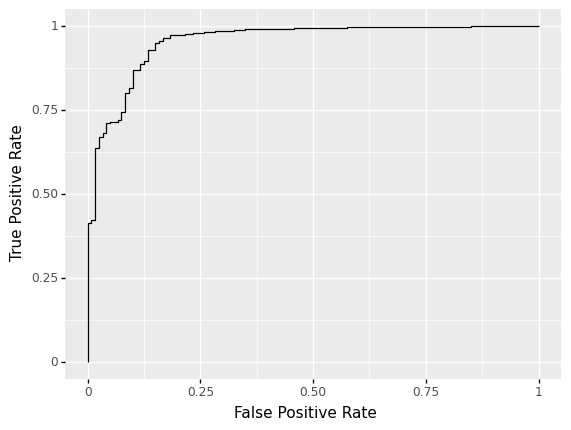

<ggplot: (343614182)>

In [22]:
plot_roc(y_test, y_test_pred_con)

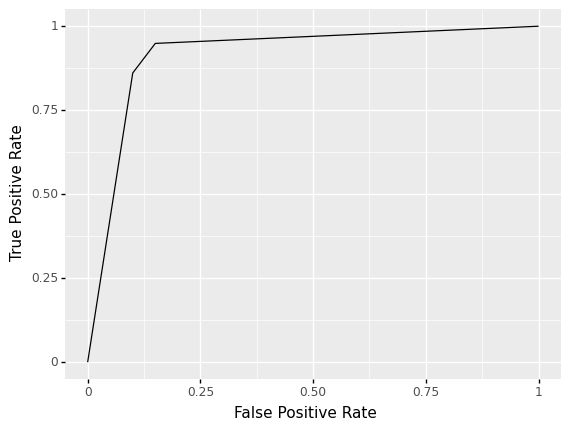

<ggplot: (343716774)>

In [23]:
plot_roc(y_test, y_test_pred_cut)

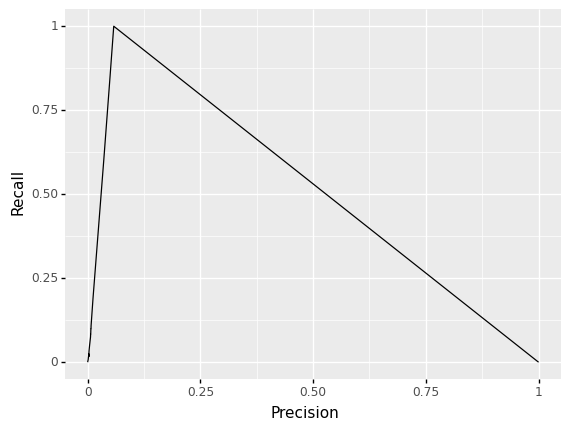

<ggplot: (343761806)>

In [24]:
plot_precision_recall(y_test, y_test_pred_con)

Plot roc curves for each classifier

In [25]:
from src.visualization.visualize import plot_roc_base_clfs

In [26]:
y_test_prob_clfs = sgclf.predict_meta_features(X_test, use_probas = True)
y_test_pred_clfs = sgclf.predict_meta_features(X_test, use_probas = False)

In [27]:
keys = [
    clf.get_params()["steps"][-1][1].__class__.__name__ 
    for clf in sgclf.base_clfs_
]

In [28]:
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    roc_auc_score
)

In [29]:
y_pred_meta_clf = sgclf.predict(X_test, use_probas = False)

In [30]:
y_test_pred_clfs = np.column_stack((y_test_pred_clfs, y_pred_meta_clf))
y_test_prob_clfs = np.column_stack((y_test_prob_clfs, y_test_pred_con))

In [31]:
from src.models.metrics import calculate_nri

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


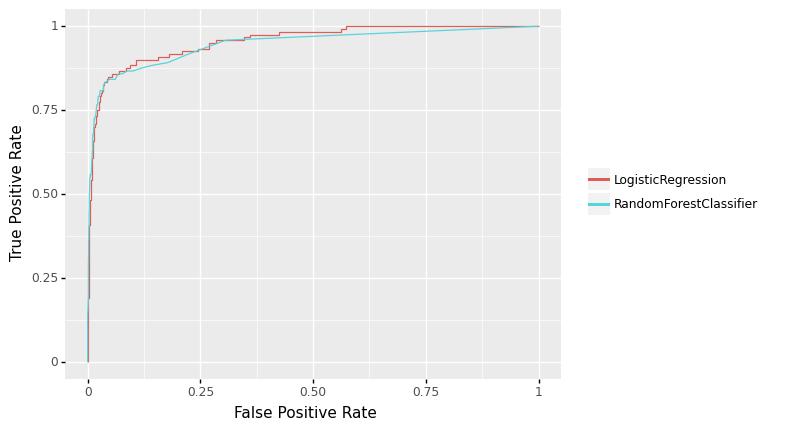

<ggplot: (359585711)>

In [32]:
plot_roc_base_clfs(y_test_prob_clfs, y_test, keys)

In [33]:
from sklearn.utils import resample
from joblib import Parallel, delayed

In [77]:
def compute_performance(y_prob: np.array, y_pred: np.array,
                        y_true: np.array, y_pred_cut: np.array = None,
                        tc: pd.Series = None):
    roc_auc = roc_auc_score(
        y_true=y_true, 
        y_score=y_prob
    )
    prec = precision_score(
        y_true=y_true, 
        y_pred=y_pred, 
        average="macro"
    )
    rec = recall_score(
        y_true=y_true, 
        y_pred=y_pred, 
        average="macro"
    )
    r = dict(roc_auc = roc_auc, prec = prec, rec = rec)
    if y_pred_cut is not None: 
        nri_metrics = ["nri", "nri_plus", "nri_minus"]
        nri = calculate_nri(
            y_true=y_true, 
            y_old=tc,
            y_new=y_pred_cut
        )
        r = {**r, **{m: nri[m] for m in nri_metrics}}

    return r

def compute_metrics(X_train: pd.DataFrame, y_train: pd.Series, 
                    X_test: pd.DataFrame, y_test: pd.Series,
                    tc: pd.Series, keys: list):
    """Computes relevant performance metrics.
    
    ROC, Precision, Recall, and NRI for the meta classifier.
    """
    # Fit classifier
    sgclf = StackedGeneralizationClassifier(
        base_clfs=base_clfs, 
        meta_clf=LogisticRegression(),
        use_probas=True, 
        verbose=False
    )
    sgclf.cv_outer_loop(
        all_hyper_parameters=all_hyper_parameters,
        X=X_train, 
        y=y_train,
        refit=True
    )
    # Predictions by the meta classifier
    y_test_prob_con, y_test_prob_cut = sgclf.predict(X_test)
    y_test_pred_meta_clf = sgclf.predict(X_test, use_probas = False)
    
    # Predictions for each base classifier
    y_test_prob_clfs = sgclf.predict_meta_features(X_test, use_probas = True)
    y_test_pred_clfs = sgclf.predict_meta_features(X_test, use_probas = False) 

    # Merge the two
    y_preds = np.column_stack((y_test_pred_clfs, y_test_pred_meta_clf))
    y_probs = np.column_stack((y_test_prob_clfs, y_test_prob_con))
    
    ds = {key: compute_performance(y_prob=prob, y_pred=pred, y_true=y_test)
         for prob, pred, key in zip(y_probs.T, y_preds.T, keys)
    }
    ## Compute nri for the meta classifier
    nri_metrics = ["nri", "nri_plus", "nri_minus"]
    nri = calculate_nri(
        y_true=y_test, 
        y_old=tc,
        y_new=y_test_prob_cut
    )
    ds[keys[-1]] = {**ds[keys[-1]], **{m: nri[m] for m in nri_metrics}}
    
    return ds


def boot_compute_metrics(X: pd.DataFrame, y: pd.Series, 
                         tc: pd.Series, training_size: int,
                         keys: list):
    """Helper to refactor compute_metrics."""
    # Prepare training and test sets
    X_train = resample(X, n_samples=training_size)
    y_train = y.loc[X_train.index]
    X_test = X.loc[~X.index.isin(X_train.index), :]
    y_test = y.loc[X_test.index]

    return compute_metrics(
        X_train=X_train,
        y_train=y_train, 
        X_test=X_test, 
        y_test=y_test, 
        tc=tc,
        keys=keys
    )


def bootstrap(X: pd.DataFrame, y: pd.Series, tc: pd.Series,
              keys: list, N: int = 5, train_size: float = 0.8, 
              n_jobs: int = 2):
    """Bootstraps statistics
    
    Parallelized computation of bootstrap performance estimates.
    
    Args:
        X: Features.
        y: Targets.
        N: Number of bootstrap samples.
        train_size: Proportion of samples in the training sample.
        n_jobs: Number of parallel processes.
        keys: Classifier keys.
        
    Returns:
        List of estimates from each bootstrap sample.
    """
    # Numbef of samples in training samples
    training_size = int(len(X.index) * train_size)
    return Parallel(n_jobs=n_jobs)(delayed(boot_compute_metrics)(X, y, tc, training_size, keys) for i in tqdm(range(N)))


def compute_bootstrap_ci(point_estimate, stats):
    """Computes confidence interval.
    
    Uses the empirical bootstrap.
    Source:
        https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf
        
    Args:
        point_estimate: Point estimate from our sample.
        stats: Estimates from each bootstrap sample.
        
    Returns:
        Tuple of lower and upper bound of confidence interval.
    """
    bs_statistics = np.sort(stats)
    delta_star = bs_statistics - point_estimate
    d1 = np.quantile(delta_star, 0.1)
    d2 = np.quantile(delta_star, 0.9)
    ub = point_estimate - d1
    lb = point_estimate - d2
    
    return lb, ub

In [78]:
def compile_performance(y_probs: pd.DataFrame, y_preds: pd.DataFrame,
                        y_true: np.array, tc: np.array, y_cut: np.array,
                        keys: list):
    # Compute prec, rec, auc for all models
    ds = [
        compute_performance(y_prob=prob, y_pred=pred, y_true=y_true) 
        for prob, pred in zip(y_probs.T, y_preds.T)
    ]
    perf_df = pd.DataFrame(ds, index = keys)
    
    # Compute nri for meta classifier
    nri_metrics = ["nri", "nri_plus", "nri_minus"]
    nri = calculate_nri(
        y_true=y_true, 
        y_old=tc, 
        y_new=y_cut
    )
    nri_df = pd.DataFrame(
        np.zeros(perf_df.shape),
        columns=nri_metrics    
    ).replace({0: None})
    nri_df.loc[len(perf_df.index) - 1, :] = np.array(nri[nri_metrics])
    nri_df.index = perf_df.index

    perf_df = pd.concat([perf_df, nri_df], axis = 1)

    return perf_df

In [79]:
stats = bootstrap(X_train, y_train, tc_train, keys + [sgclf.__class__.__name__])

  0%|          | 0/5 [00:00<?, ?it/s]

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 
R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:

R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:



  0%|          | 0/4 [00:00<?, ?it/s]
                Estimate
NRI            0.8371654
NRI+           0.9478022
NRI-          -0.1106368
Pr(Up|Case)    0.9478022
Pr(Down|Case)  0.0000000
Pr(Down|Ctrl)  0.1009049
Pr(Up|Ctrl)    0.2115417
  0%|          | 0/4 [00:00<?, ?it/s]
                  Estimate
NRI           0.8816968219
NRI+          0.8813559322
NRI-          0.0003408897
Pr(Up|Case)   0.8813559322
Pr(Down|Case) 0.0000000000
Pr(Down|Ctrl) 0.1123231635
Pr(Up|Ctrl)   0.1119822737


R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:

R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:



  0%|          | 0/4 [00:00<?, ?it/s]
                Estimate
NRI           0.87365229
NRI+          0.84802432
NRI-          0.02562797
Pr(Up|Case)   0.87234043
Pr(Down|Case) 0.02431611
Pr(Down|Ctrl) 0.11575017
Pr(Up|Ctrl)   0.09012220
  0%|          | 0/4 [00:00<?, ?it/s]
                Estimate
NRI           0.81501311
NRI+          0.79054054
NRI-          0.02447257
Pr(Up|Case)   0.80743243
Pr(Down|Case) 0.01689189
Pr(Down|Ctrl) 0.11358650
Pr(Up|Ctrl)   0.08911392


/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

  0%|          | 0/4 [00:00<?, ?it/s]
                Estimate
NRI           0.80658775
NRI+          0.76377953
NRI-          0.04280822
Pr(Up|Case)   0.79527559
Pr(Down|Case) 0.03149606
Pr(Down|Ctrl) 0.11455479
Pr(Up|Ctrl)   0.07174658


R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:



In [129]:
# Set bootstrap estimates as data frame
stats_df = pd.concat([pd.DataFrame.from_dict(d, orient="index").stack().to_frame() for d in stats], axis = 1)
stats_df.values.sort()
# Set list for simplifying compiling point estimates
y_test_pred_cuts = [None] * len(keys) + [y_test_pred_cut]
# Set point estimates as data frame
point_estimates = pd.DataFrame.from_dict({
    k: compute_performance(
        y_prob=prob, 
        y_pred=pred, 
        y_true=y_test, 
        y_pred_cut=cut, 
        tc=tc_test
    )
    for prob, pred, cut, k in zip(
        y_test_prob_clfs.T, 
        y_test_pred_clfs.T,
        y_test_pred_cuts,
        keys + [sgclf.__class__.__name__]
    )
}, orient = "index").stack().to_frame()
point_estimates
# Compute quantiles for each metric
d1 = (stats_df - point_estimates).apply(np.quantile, q = 0.1, axis = 1)
d2 = (stats_df - point_estimates).apply(np.quantile, q = 0.9, axis = 1)
# Compute upper bounds and lower bounds
ub = point_estimates - d1.to_frame()
lb = point_estimates - d2.to_frame()
# Compile performamance
perf_df = pd.concat([point_estimates, lb, ub, ], axis = 1)

R[write to console]: 
NRI estimation:

R[write to console]: Point estimates:



                 Estimate
NRI            0.36833845
NRI+           0.43333333
NRI-          -0.06499488
Pr(Up|Case)    0.47500000
Pr(Down|Case)  0.04166667
Pr(Down|Ctrl)  0.05783009
Pr(Up|Ctrl)    0.12282497


In [130]:
lb_str = lb.iloc[:, 0].round(2).astype(str) 
ub_str = ub.iloc[:, 0].round(2).astype(str)
pe_str = point_estimates.iloc[:, 0].round(2).astype(str)
ci = pe_str + " (" + lb_str + " to " + ub_str +  ")"

In [131]:
perf_df = pd.concat([perf_df, ci.to_frame()], axis = 1)
perf_df.columns = ["point_estimate", "lb", "ub", "ci"]

In [133]:
perf_df

point_estimate        lb        ub  \
LogisticRegression              roc_auc          0.956158  0.950536  0.965152   
                                prec             0.876429  0.851456  0.882623   
                                rec              0.798793  0.781851  0.817703   
RandomForestClassifier          roc_auc          0.945752  0.932163  0.945469   
                                prec             0.884882  0.863481  0.908303   
                                rec              0.799305  0.777238  0.826087   
StackedGeneralizationClassifier roc_auc          0.955489  0.946148  0.958432   
                                prec             0.896257  0.877160  0.917436   
                                rec              0.808150  0.812261  0.851645   
                                nri              0.368338 -0.141802 -0.073281   
                                nri_plus         0.433333 -0.054557  0.092183   
                                nri_minus       -0.064995 -0.165926 -0.063744   

                                                               ci  
LogisticRegression              roc_auc       0.96 (0.95 to 0.97)  
                                prec          0.88 (0.85 to 0.88)  
                                rec            0.8 (0.78 to 0.82)  
RandomForestClassifier          roc_auc       0.95 (0.93 to 0.95)  
                                prec          0.88 (0.86 to 0.91)  
                                rec            0.8 (0.78 to 0.83)  
StackedGeneralizationClassifier roc_auc       0.96 (0.95 to 0.96)  
                                prec           0.9 (0.88 to 0.92)  
                                rec           0.81 (0.81 to 0.85)  
                                nri         0.37 (-0.14 to -0.07)  
                                nri_plus     0.43 (-0.05 to 0.09)  
                                nri_minus  -0.06 (-0.17 to -0.06)